# 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input/digit-recognizer"))

# 2. Define Image PROPERTIES

In [ ]:
FAST_RUN = False
# following properties are mentioned in 
IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# channel refer to number of colors, here GrayScale
IMAGE_CHANNELS=1

# 3. Prepare dataset for training model

In [ ]:
# import important data
train_data = pd.read_csv("../input/digit-recognizer/train.csv")
test_data = pd.read_csv("../input/digit-recognizer/test.csv")

In [ ]:
train_data.head()
# it is seen that total pixel of an image are 784 (i.e 28x28 matrix)

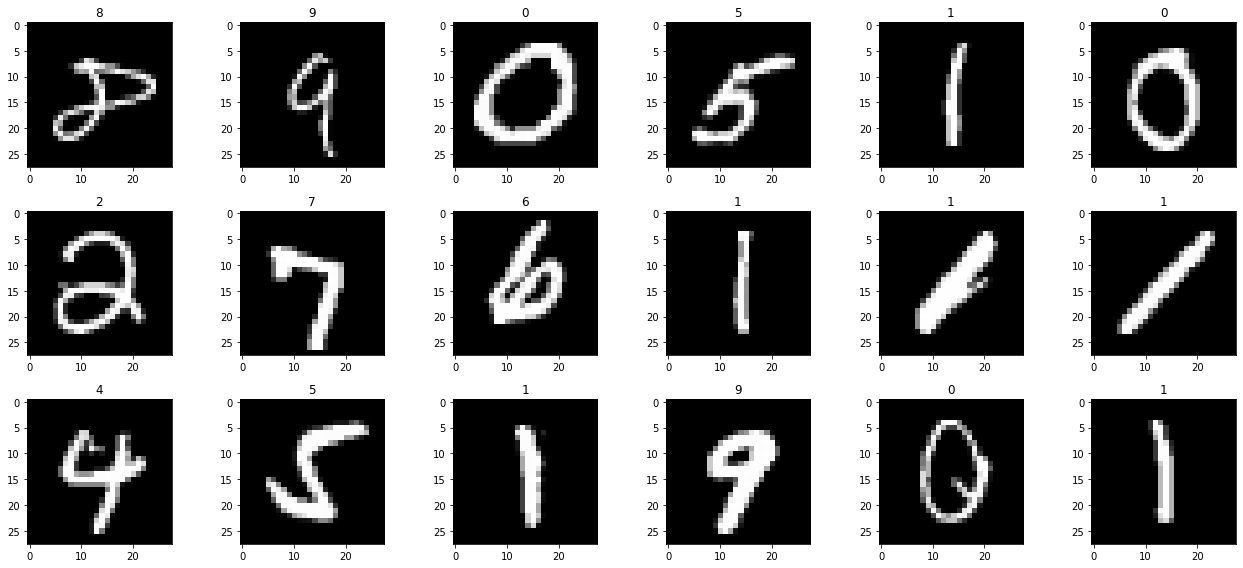

In [29]:
# function to display image
def show_image(train_image, label, index):
    
    #converting 784x1 to 28x28
    image_shaped = train_image.values.reshape(28,28)
    
    #3 - no. of rows, 6 - no. of columns
    plt.subplot(3, 6, index+1)
    
    #plotting grayscale image
    plt.imshow(image_shaped, cmap=plt.cm.gray)
    plt.title(label)


#size of total figure
plt.figure(figsize=(18, 8))
sample_image = train_data.sample(18).reset_index(drop=True)
for index, row in sample_image.iterrows():
    # storing 1st columns i.e. label column
    label = row['label']
    # storing all columns except label
    image_pixels = row.drop('label')
    show_image(image_pixels, label, index)

plt.tight_layout()

# 4. Create a Sequential Model

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

# Keras defines a sequential model as a sequential stack of linear layers.
model=Sequential()

# here we using 32 filter layers and kernel size of (3,3), with relu activation function (max(0,x))
# Batch normalization() is a technique for improving the speed, performance, and stability of cnn.
# max pooling reduces the dimensionality of images by reducing the number of pixels in the output from previous cnn
# pool size define size of filter


#1st layer is input layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten convert matrix into single array
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())


# Finally we compile our model with rsmprop optimizer
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

# 5. Analyzing model

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)             

# 6. CALLBACK

In [42]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#One way to avoid overfitting is to terminate the process early using earlystop
earlystop = EarlyStopping(patience = 10)

# Following line will reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]


# 7. Manage DATA

In [43]:
x = train_data.drop(columns=['label']).values.reshape(train_data.shape[0],28,28,1)
y = to_categorical(train_data['label'])

#using train_test_split to split your data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# batch_size specifies how many training samples should be sent to the model at once.
batch_size=32


# 8. Training & Validation Generator (DATA AUGMENTATION)

In [44]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(x_test)
validation_generator = validation_datagen.flow(
    x_test,
    y_test
    
)

# 9. Training Model

In [45]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=len(x_train) // batch_size, 
    validation_data=validation_generator,
    validation_steps=len(x_test) // batch_size,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
1181/1181 [==============================] - 44s 37ms/step - loss: 0.2106 - accuracy: 0.9346 - val_loss: 0.0077 - val_accuracy: 0.9773
Epoch 2/10
   4/1181 [..............................] - ETA: 47s - loss: 0.0671 - accuracy: 0.9766

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1181/1181 [==============================] - 43s 37ms/step - loss: 0.0979 - accuracy: 0.9711 - val_loss: 0.0958 - val_accuracy: 0.9803
Epoch 3/10
1181/1181 [==============================] - 44s 37ms/step - loss: 0.0751 - accuracy: 0.9782 - val_loss: 0.0063 - val_accuracy: 0.9868
Epoch 4/10
1181/1181 [==============================] - 43s 36ms/step - loss: 0.0673 - accuracy: 0.9784 - val_loss: 0.0115 - val_accuracy: 0.9873
Epoch 5/10
1181/1181 [==============================] - 43s 37ms/step - loss: 0.0597 - accuracy: 0.9820 - val_loss: 0.0046 - val_accuracy: 0.9904
Epoch 6/10
1181/1181 [==============================] - 44s 37ms/step - loss: 0.0549 - accuracy: 0.9839 - val_loss: 0.1066 - val_accuracy: 0.9851
Epoch 7/10
1181/1181 [==============================] - 43s 37ms/step - loss: 0.0544 - accuracy: 0.9842 - val_loss: 0.0227 - val_accuracy: 0.9868
Epoch 8/10
1181/1181 [==============================] - 43s 36ms/step - loss: 0.0483 - accuracy: 0.9857 - val_loss: 0.0776 - val_accura

# 10. Evaluate Model

In [46]:
x_test_recaled = (x_test.astype("float32") / 255)
scores = model.evaluate(x_test_recaled, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

accuracy: 98.95%
loss: 4.03%


# 11. Prediction

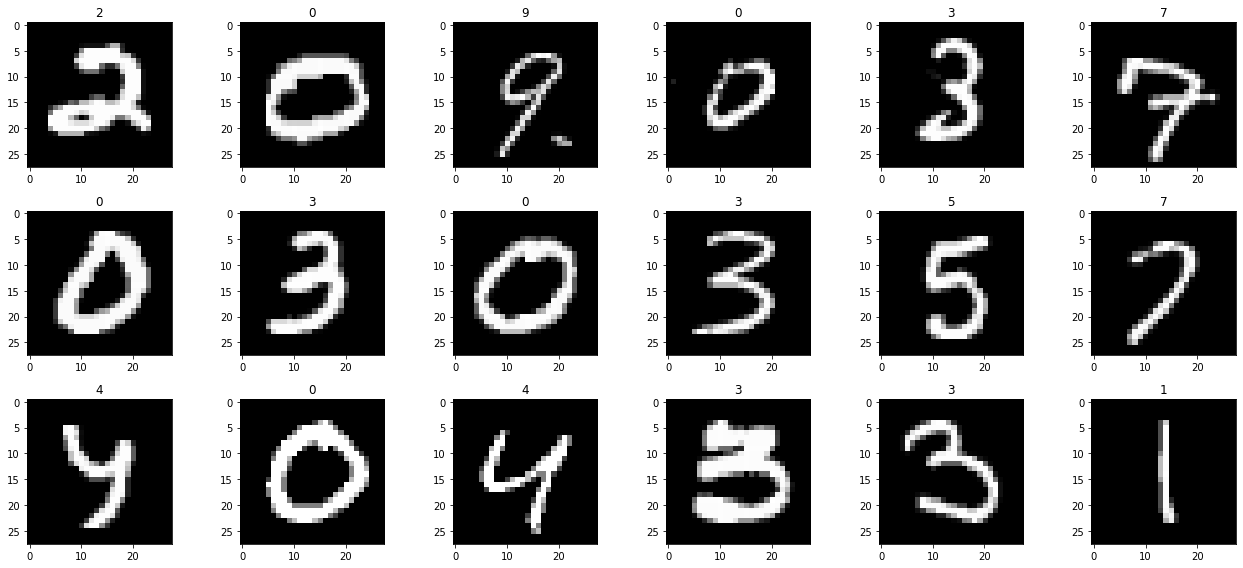

In [47]:
test_digit_data = test_data.values.reshape(test_data.shape[0],28,28,1).astype("float32") / 255
predictions = model.predict(test_digit_data)
results = np.argmax(predictions, axis = 1)

plt.figure(figsize=(18, 8))
sample_test = test_data.head(18)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    show_image(image_pixels, label, index)
plt.tight_layout()

# 12. Create submission file

In [56]:
submissions = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submissions['Label'] = results
submissions.to_csv('sample_submission.csv', index = False)

# END